In [142]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Flatten, TextVectorization, Attention
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision, layers, metrics, backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve
mixed_precision.set_global_policy('mixed_float16')

In [110]:
ebnerd_type = "ebnerd_large"

In [111]:
# load datasets
behaviors = pd.read_parquet(f"{ebnerd_type}/train/behaviors.parquet").dropna()
history = pd.read_parquet(f"{ebnerd_type}/train/history.parquet").dropna()
articles = pd.read_parquet(f"{ebnerd_type}/articles.parquet").dropna()
articles_embeddings = pd.read_parquet(f"{ebnerd_type}/bert_base_multilingual_cased.parquet")

In [112]:
behaviors['article_id'] = behaviors['article_id'].astype(int)

In [113]:
train_behaviors = behaviors[behaviors['impression_time'] < '2023-05-23 07:00:00']
val_behaviors = behaviors[(behaviors['impression_time'] >= '2023-05-23 07:00:00') &
                        (behaviors['impression_time'] < '2023-05-24 07:00:00')]
test_behaviors = behaviors[behaviors['impression_time'] >= '2023-05-24 07:00:00']

In [114]:
# generate user-item interactions with positive and negative samples
test_user_item_pairs = []
val_user_item_pairs = []
train_user_item_pairs = []
unique_users = behaviors['user_id'].unique()
unique_items = articles['article_id'].unique()

for user_id in unique_users:
    # get all sessions for this user
    user_data = train_behaviors[train_behaviors['user_id'] == user_id]

    # iterate over each session to gather clicked and non-clicked inview articles
    for _, session in user_data.iterrows():
        # extract clicked and inview article IDs for the session
        clicked_articles = set(session['article_ids_clicked']) if len(session['article_ids_clicked']) > 0 else set()
        inview_articles = set(session['article_ids_inview']) if len(session['article_ids_inview']) > 0 else set()

        impression_id = session['impression_id']
        impression_time = session['impression_time']

        # add positive samples (clicked articles)
        for article_id in clicked_articles:
            train_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 1])  # Interaction = 1 for positive samples

        # identify non-clicked inview articles as additional negative samples
        non_clicked_inview = list(inview_articles - clicked_articles)

        non_clicked_inview = random.sample(non_clicked_inview, min(3 * len(clicked_articles), len(non_clicked_inview)))

        for article_id in non_clicked_inview:
            train_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 0])  # interaction = 0 for non-clicked inview articles

for user_id in unique_users:
    # get all sessions for this user
    user_data = val_behaviors[val_behaviors['user_id'] == user_id]

    # iterate over each session to gather clicked and non-clicked inview articles
    for _, session in user_data.iterrows():
        # extract clicked and inview article IDs for the session
        clicked_articles = set(session['article_ids_clicked']) if len(session['article_ids_clicked']) > 0 else set()
        inview_articles = set(session['article_ids_inview']) if len(session['article_ids_inview']) > 0 else set()

        impression_id = session['impression_id']
        impression_time = session['impression_time']

        # add positive samples (clicked articles)
        for article_id in clicked_articles:
            val_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 1])  # Interaction = 1 for positive samples

        # identify non-clicked inview articles as additional negative samples
        non_clicked_inview = random.sample(non_clicked_inview, min(3 * len(clicked_articles), len(non_clicked_inview)))


        for article_id in non_clicked_inview:
            val_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 0])  # interaction = 0 for non-clicked inview articles

for user_id in unique_users:
    # get all sessions for this user
    user_data = test_behaviors[test_behaviors['user_id'] == user_id]

    # iterate over each session to gather clicked and non-clicked inview articles
    for _, session in user_data.iterrows():
        # extract clicked and inview article IDs for the session
        clicked_articles = set(session['article_ids_clicked']) if len(session['article_ids_clicked']) > 0 else set()
        inview_articles = set(session['article_ids_inview']) if len(session['article_ids_inview']) > 0 else set()

        impression_id = session['impression_id']
        impression_time = session['impression_time']

        # add positive samples (clicked articles)
        for article_id in clicked_articles:
            test_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 1])  # Interaction = 1 for positive samples

        # identify non-clicked inview articles as additional negative samples
        non_clicked_inview = list(inview_articles - clicked_articles)
        non_clicked_inview = random.sample(non_clicked_inview, min(3 * len(clicked_articles), len(non_clicked_inview)))

        for article_id in non_clicked_inview:
            test_user_item_pairs.append([user_id, article_id, impression_id, impression_time, 0])  # interaction = 0 for non-clicked inview articles

In [115]:
# convert to DataFrame
train_interactions_df = pd.DataFrame(train_user_item_pairs, columns=['user_id', 'article_id', 'impression_id', 'impression_time', 'interaction'])
val_interactions_df = pd.DataFrame(val_user_item_pairs, columns=['user_id', 'article_id', 'impression_id', 'impression_time', 'interaction'])
test_interactions_df = pd.DataFrame(test_user_item_pairs, columns=['user_id', 'article_id', 'impression_id', 'impression_time', 'interaction'])

In [116]:
train_interactions_df = pd.merge(
    train_interactions_df,
    articles[['article_id', 'category', 'premium']],
    on='article_id',
    how='left'
)
val_interactions_df = pd.merge(
    val_interactions_df,
    articles[['article_id', 'category', 'premium']],
    on='article_id',
    how='left'
)
test_interactions_df = pd.merge(
    test_interactions_df,
    articles[['article_id', 'category', 'premium']],
    on='article_id',
    how='left'
)

In [117]:
train_interactions_df['category'] = train_interactions_df['category'].fillna(-1).astype(int)
val_interactions_df['category'] = val_interactions_df['category'].fillna(-1).astype(int)
test_interactions_df['category'] = test_interactions_df['category'].fillna(-1).astype(int)

In [118]:
history_features = history.groupby('user_id').agg({
    'read_time_fixed': lambda x: np.nanmean([t for t in x if t is not None]),  # average read time
    'scroll_percentage_fixed': lambda x: np.nanmean([s for s in x if s is not None]),  # average scroll percentage
    'article_id_fixed': 'count'  # total clicks
}).reset_index()

history_features.columns = ['user_id', 'avg_read_time', 'avg_scroll_percentage', 'total_clicks']

<ipython-input-118-8ff48d8cb124>:3: RuntimeWarning: Mean of empty slice
  'scroll_percentage_fixed': lambda x: np.nanmean([s for s in x if s is not None]),  # average scroll percentage


In [119]:
train_interactions_df = pd.merge(
    train_interactions_df,
    history_features[['user_id', 'avg_read_time', 'avg_scroll_percentage', 'total_clicks']],
    on='user_id',
    how='left'
)
val_interactions_df = pd.merge(
    val_interactions_df,
    history_features[['user_id', 'avg_read_time', 'avg_scroll_percentage', 'total_clicks']],
    on='user_id',
    how='left'
)
test_interactions_df = pd.merge(
    test_interactions_df,
    history_features[['user_id', 'avg_read_time', 'avg_scroll_percentage', 'total_clicks']],
    on='user_id',
    how='left'
)

In [120]:
# fav category
article_category_map = dict(zip(articles['article_id'], articles['category']))

In [121]:
def get_favorite_category(row):
    """
    Determine the favorite category for a user based on the articles they have read.
    """
    user_id = row['user_id']
    article_ids = row['article_id_fixed']

    # map article IDs to categories using the dictionary
    categories = [article_category_map.get(article_id) for article_id in article_ids if article_id in article_category_map]

    # count the frequency of each category and get the most common one
    if categories:
        category_count = Counter(categories)
        favorite_category = category_count.most_common(1)[0][0]  # get the most common category
    else:
        favorite_category = 'Unknown'

    return pd.Series({'user_id': user_id, 'favorite_category': favorite_category})

In [122]:
user_favorite_categories = history.apply(get_favorite_category, axis=1)

In [123]:
train_interactions_df = pd.merge(
    train_interactions_df,
    user_favorite_categories,
    on='user_id',
    how='left'
)
val_interactions_df = pd.merge(
    val_interactions_df,
    user_favorite_categories,
    on='user_id',
    how='left'
)
test_interactions_df = pd.merge(
    test_interactions_df,
    user_favorite_categories,
    on='user_id',
    how='left'
)

In [124]:
train_interactions_df['favorite_category'].fillna(-1, inplace=True)
val_interactions_df['favorite_category'].fillna(-1, inplace=True)
test_interactions_df['favorite_category'].fillna(-1, inplace=True)

<ipython-input-124-66b09f608afc>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_interactions_df['favorite_category'].fillna(-1, inplace=True)
<ipython-input-124-66b09f608afc>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [125]:
# user info
user_info = behaviors[['user_id', 'gender', 'postcode', 'age', 'is_subscriber',
                            'next_read_time', 'next_scroll_percentage']].sort_values(by='next_read_time', ascending=False).drop_duplicates(subset=['user_id'])

In [126]:
train_interactions_df = pd.merge(
    train_interactions_df,
    user_info,
    on='user_id',
    how='left'
)
val_interactions_df = pd.merge(
    val_interactions_df,
    user_info,
    on='user_id',
    how='left'
)
test_interactions_df = pd.merge(
    test_interactions_df,
    user_info,
    on='user_id',
    how='left'
)

In [83]:
# save to parquet - no embeddings
train_interactions_df.to_parquet(f"interactions_train.parquet")
val_interactions_df.to_parquet(f"interactions_val.parquet")
test_interactions_df.to_parquet(f"interactions_test.parquet")

In [127]:
# add embeddings
train_interactions_df = pd.merge(
    train_interactions_df,
    articles_embeddings,
    on='article_id',
    how='left'
)
val_interactions_df = pd.merge(
    val_interactions_df,
    articles_embeddings,
    on='article_id',
    how='left'
)
test_interactions_df = pd.merge(
    test_interactions_df,
    articles_embeddings,
    on='article_id',
    how='left'
)

In [128]:
# save to parquet - embeddings
train_interactions_df.to_parquet(f"interactions_train_embeddings.parquet")
val_interactions_df.to_parquet(f"interactions_val_embeddings.parquet")
test_interactions_df.to_parquet(f"interactions_test_embeddings.parquet")

In [86]:
train_interactions_df = pd.read_parquet(f"interactions_train_embeddings.parquet")
val_interactions_df = pd.read_parquet(f"interactions_val_embeddings.parquet")
test_interactions_df = pd.read_parquet(f"interactions_test_embeddings.parquet")

In [129]:
# split into test, train, validation
train_df = train_interactions_df
val_df = val_interactions_df
test_df = test_interactions_df
print(f"Train set: {len(train_df)}, Validation set: {len(val_df)}, Test set: {len(test_df)}")

Train set: 138506, Validation set: 26629, Test set: 33597


In [130]:
unique_users = behaviors['user_id'].unique()
unique_articles = behaviors['article_id'].unique()
unique_categories = articles['category'].unique()

In [131]:
categorical_features = ['user_id', 'article_id', 'category', 'favorite_category', 'gender', 'postcode', 'is_subscriber']

In [132]:
encoders = {}
for feature in categorical_features:
    encoder = LabelEncoder()
    train_df[feature] = encoder.fit_transform(train_df[feature])
    val_df[feature] = encoder.fit_transform(val_df[feature])
    test_df[feature] = encoder.fit_transform(test_df[feature])
    encoders[feature] = encoder

In [133]:
# normalize numerical features
numerical_features = ['avg_read_time', 'avg_scroll_percentage', 'total_clicks', 'age', 'next_read_time', 'next_scroll_percentage']
scaler = StandardScaler()
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
val_df[numerical_features] = scaler.transform(val_df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

In [134]:
# extract BERT embeddings into a numpy array
train_df['bert_embeddings'] = train_df['google-bert/bert-base-multilingual-cased'].apply(lambda x: np.array(x))
train_df_bert_embeddings = np.stack(train_df['bert_embeddings'].values)

val_df['bert_embeddings'] = val_df['google-bert/bert-base-multilingual-cased'].apply(lambda x: np.array(x))
val_df_bert_embeddings = np.stack(val_df['bert_embeddings'].values)

test_df['bert_embeddings'] = test_df['google-bert/bert-base-multilingual-cased'].apply(lambda x: np.array(x))
test_df_bert_embeddings = np.stack(test_df['bert_embeddings'].values)

In [135]:
def prepare_inputs(df):
    categorical_inputs = df[categorical_features].values
    numerical_inputs = df[numerical_features].values
    bert_embeddings = np.stack(df['bert_embeddings'].values)
    return [categorical_inputs, numerical_inputs, bert_embeddings]

In [136]:
train_inputs = prepare_inputs(train_df)
val_inputs = prepare_inputs(val_df)
test_inputs = prepare_inputs(test_df)

train_labels = train_df['interaction'].values
val_labels = val_df['interaction'].values
test_labels = test_df['interaction'].values

In [137]:
# define feature input layers
categorical_input = layers.Input(shape=(len(categorical_features),), name='categorical_input')
numerical_input = layers.Input(shape=(len(numerical_features),), name='numerical_input')
bert_input = layers.Input(shape=(train_df_bert_embeddings.shape[1],), name='bert_input')

In [138]:
# embedding and dense layers for categorical features
x1 = layers.Embedding(input_dim=len(unique_users), output_dim=32)(categorical_input)
x1 = layers.Flatten()(x1)

# dense layers for numerical features
x2 = layers.Dense(32, activation='relu')(numerical_input)

# use BERT embeddings directly
x3 = layers.Dense(128, activation='relu')(bert_input)

# concatenate all features
x = layers.Concatenate()([x1, x2, x3])
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

In [144]:
# define the model
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = -alpha_t * K.pow((1 - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed

model = Model(inputs=[categorical_input, numerical_input, bert_input], outputs=output)
model.compile(optimizer='adam', loss=focal_loss(gamma=2, alpha=0.25), metrics=[metrics.AUC()])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ categorical_input         │ (None, 7)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 7, 32)          │        147,616 │ categorical_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numerical_input           │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_input (InputLayer)   │ (None, 768)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 224)            │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │            224 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 128)            │         98,432 │ bert_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 384)            │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ dense_10[0][0],        │
│                           │                        │                │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 64)             │         24,640 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 32)             │          2,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 1)              │             33 │ dense_13[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 273,025 (1.04 MB)

 Trainable params: 273,025 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [147]:
# fine tuning
# lr scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc_3',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [148]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc_3',
    patience=5,
    restore_best_weights=True,
    mode='max'
)
# train the model
history = model.fit(
    [train_inputs[0], train_inputs[1], train_inputs[2]], train_labels,
    validation_data=([val_inputs[0], val_inputs[1], val_inputs[2]], val_labels),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[lr_scheduler],
    verbose=1
)

Epoch 1/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_3: 0.6893 - loss: 0.0516 - val_auc_3: 0.2943 - val_loss: 0.0655 - learning_rate: 0.0010
Epoch 2/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_3: 0.6906 - loss: 0.0513 - val_auc_3: 0.2903 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 3/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_3: 0.6924 - loss: 0.0516 - val_auc_3: 0.2982 - val_loss: 0.0636 - learning_rate: 0.0010
Epoch 4/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_3: 0.6930 - loss: 0.0516 - val_auc_3: 0.3356 - val_loss: 0.0650 - learning_rate: 0.0010
Epoch 5/50
2145/2165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc_3: 0.6907 - loss: 0.0516
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_3: 0.6907 - loss: 0.0516 - val_auc_3: 0.3378 - val_loss: 0.0604 - learning_rate: 0.0010
Epoch 6/50
2165/2165 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc_3: 0.6963 - loss: 0.0509 - val_auc_3: 0.3425 - val

In [149]:
# predict on the test set
test_preds = model.predict([test_inputs[0], test_inputs[1], test_inputs[2]]).flatten()
test_df['predicted_score'] = test_preds

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


In [150]:
print(test_df[['impression_id', 'user_id', 'article_id','interaction', 'predicted_score']])

       impression_id  user_id  article_id  interaction  predicted_score
0          111126579      430        1101            1         0.239502
1          111126579      430        1128            0         0.264648
2          111126579      430        1100            0         0.275635
3          111126579      430         335            0         0.282471
4          111126582      430        1062            1         0.259033
...              ...      ...         ...          ...              ...
33592      576838064     1309         774            0         0.245728
33593      576838068     1309         902            1         0.258789
33594      576838068     1309        1106            0         0.358643
33595      576838068     1309        1120            0         0.274414
33596      576838068     1309        1110            0         0.334961

[33597 rows x 5 columns]


In [151]:
#metrics
# AUC
def calculate_auc(data):
    """Calculate AUC for a given dataset."""
    if data['interaction'].nunique() < 2:  # AUC needs at least one positive and one negative label
        return np.nan
    return roc_auc_score(data['interaction'], data['predicted_score'])

# MRR calculation
def calculate_mrr(data):
    """Calculate MRR for a given dataset."""
    sorted_data = data.sort_values(by='predicted_score', ascending=False)
    ranks = sorted_data['interaction'].values
    for rank, interaction in enumerate(ranks, start=1):
        if interaction == 1:
            return 1 / rank
    return 0

# NDCG calculation
def dcg(scores, k):
    """Calculate Discounted Cumulative Gain."""
    return sum([score / np.log2(idx + 2) for idx, score in enumerate(scores[:k])])

def calculate_ndcg(data, k):
    """Calculate NDCG for a given dataset and cutoff k."""
    sorted_data = data.sort_values(by='predicted_score', ascending=False)
    ideal_sorted_data = data.sort_values(by='interaction', ascending=False)
    dcg_k = dcg(sorted_data['interaction'].values, k)
    idcg_k = dcg(ideal_sorted_data['interaction'].values, k)
    return dcg_k / idcg_k if idcg_k > 0 else 0


In [152]:
def evaluate_model(test_df):
    """Evaluate the model using AUC, MRR, and NDCG metrics."""
    auc = test_df.groupby('impression_id').apply(calculate_auc).mean()
    mrr = test_df.groupby('impression_id').apply(calculate_mrr).mean()
    ndcg3 = test_df.groupby('impression_id').apply(lambda x: calculate_ndcg(x, k=3)).mean()
    ndcg5 = test_df.groupby('impression_id').apply(lambda x: calculate_ndcg(x, k=5)).mean()

    print(f"AUC: {auc:.4f}")
    print(f"MRR: {mrr:.4f}")
    print(f"NDCG@3: {ndcg3:.4f}")
    print(f"NDCG@5: {ndcg5:.4f}")

In [153]:
# evaluate model
evaluate_model(test_df)

<ipython-input-152-65e93270f400>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  auc = test_df.groupby('impression_id').apply(calculate_auc).mean()
<ipython-input-152-65e93270f400>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mrr = test_df.groupby('impression_id').apply(calculate_mrr).mean()
<ipython-input-152-65e93270f400>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

AUC: 0.5204
MRR: 0.5432
NDCG@3: 0.5520
NDCG@5: 0.6569


<ipython-input-152-65e93270f400>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ndcg5 = test_df.groupby('impression_id').apply(lambda x: calculate_ndcg(x, k=5)).mean()


In [154]:
def evaluate_by_impression(test_data):
    results = []
    grouped = test_data.groupby('impression_id')

    for impression_id, group in grouped:
        auc = calculate_auc(group)
        mrr = calculate_mrr(group)
        ndcg3 = calculate_ndcg(group, 3)
        ndcg5 = calculate_ndcg(group, 5)
        ndcg10 = calculate_ndcg(group, 10)

        # Append the result as a dictionary
        results.append({
            'impression_id': impression_id,
            'AUC': auc,
            'MRR': mrr,
            'NDCG@3': ndcg3,
            'NDCG@5': ndcg5,
            'NDCG@10': ndcg10
        })

    # Convert results to DataFrame
    return pd.DataFrame(results)

In [155]:
results = evaluate_by_impression(test_df)
print(results)

      impression_id       AUC       MRR   NDCG@3    NDCG@5   NDCG@10
0           2432082  0.333333  0.333333  0.50000  0.500000  0.500000
1           2433185  0.666667  0.500000  0.63093  0.630930  0.630930
2           2433200  0.000000  0.250000  0.00000  0.430677  0.430677
3           2433566  0.333333  0.333333  0.50000  0.500000  0.500000
4           2433570  0.666667  0.500000  0.63093  0.630930  0.630930
...             ...       ...       ...      ...       ...       ...
8387      576859326  1.000000  1.000000  1.00000  1.000000  1.000000
8388      576859327  0.000000  0.250000  0.00000  0.430677  0.430677
8389      576859332  0.666667  0.500000  0.63093  0.630930  0.630930
8390      576859333  0.666667  0.500000  0.63093  0.630930  0.630930
8391      576859400  0.333333  0.333333  0.50000  0.500000  0.500000

[8392 rows x 6 columns]


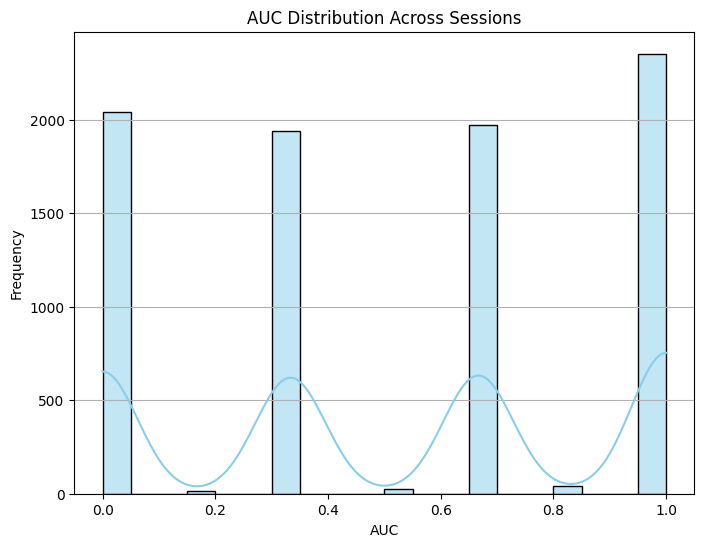

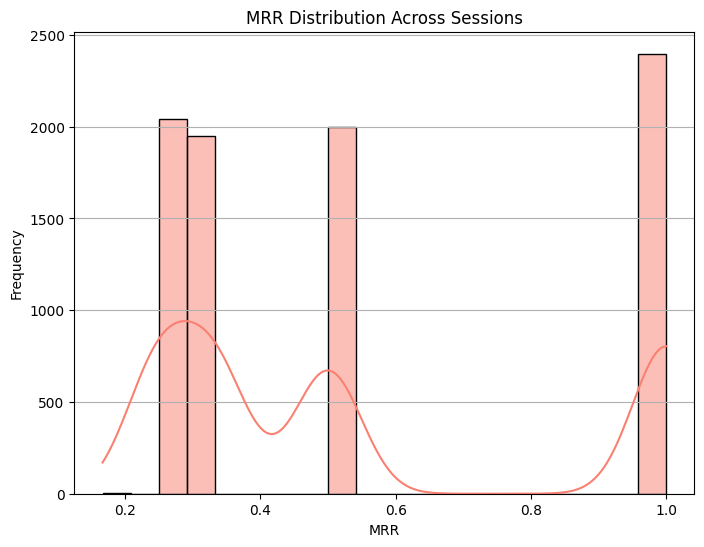

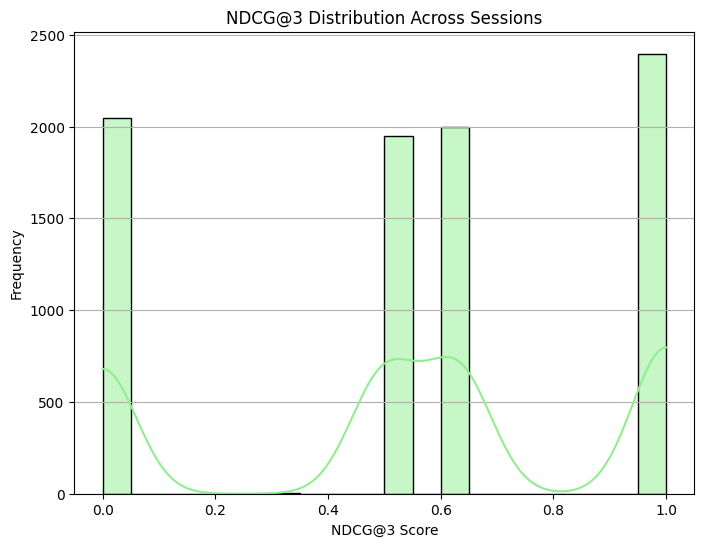

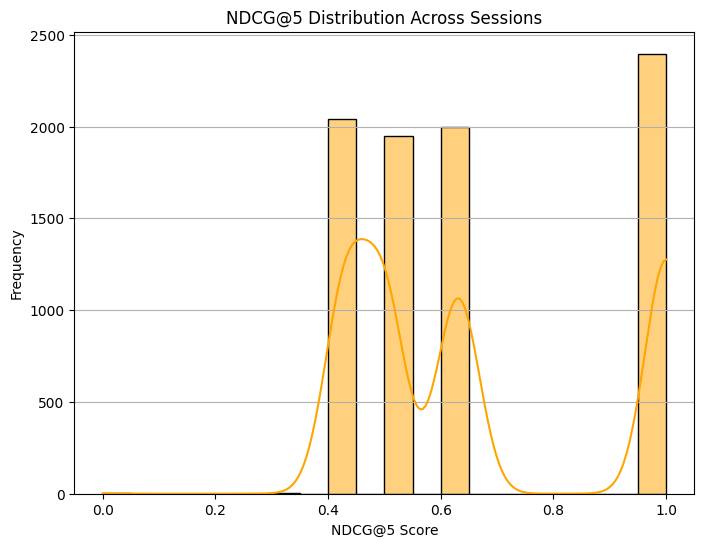

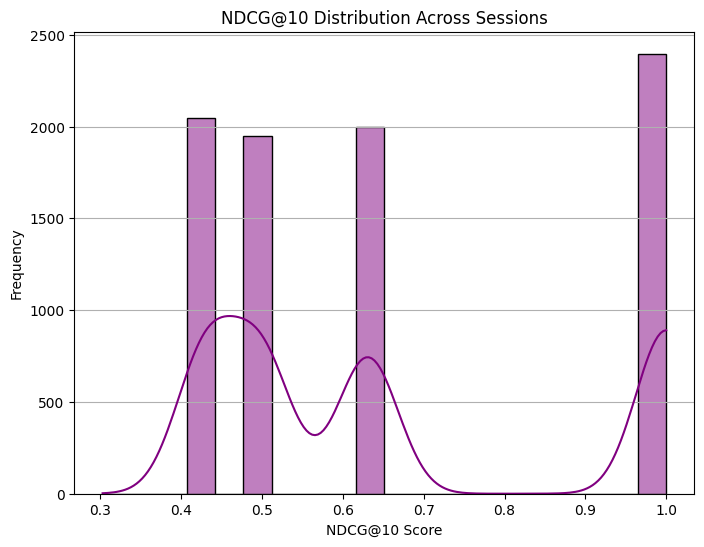

In [156]:
# Set the number of bins for histograms
bins = 20

# Plot 1: AUC Distribution Across Sessions
plt.figure(figsize=(8, 6))
sns.histplot(results['AUC'], kde=True, color="skyblue", bins=bins)
plt.title("AUC Distribution Across Sessions")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# Plot 2: MRR Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['MRR'], kde=True, color="salmon", bins=bins)
plt.title("MRR Distribution Across Sessions")
plt.xlabel("MRR")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# Plot 3: NDCG@3 Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['NDCG@3'], kde=True, color="lightgreen", bins=bins)
plt.title("NDCG@3 Distribution Across Sessions")
plt.xlabel("NDCG@3 Score")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# Plot 4: NDCG@5 Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['NDCG@5'], kde=True, color="orange", bins=bins)
plt.title("NDCG@5 Distribution Across Sessions")
plt.xlabel("NDCG@5 Score")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# Plot 5: NDCG@10 Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['NDCG@10'], kde=True, color="purple", bins=bins)
plt.title("NDCG@10 Distribution Across Sessions")
plt.xlabel("NDCG@10 Score")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()